In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#needed for visulalization of fraud vs. non-fraud and features vs. missing values
import matplotlib.pyplot as plt
import seaborn as sns

#needed for wordcloud
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

#needed for stopwords and tokenizing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

Using nltk to determine the stop words

In [23]:
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hugo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df = pd.read_csv("fake_job_postings.csv")
print(df.head(5))



   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

Visulization of the fradulent vs. non-fradulent

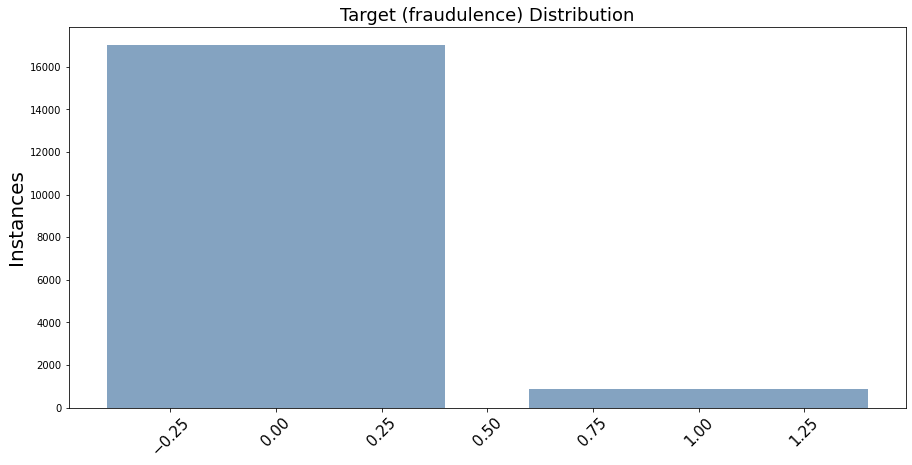

In [33]:
#Check target value
figure = plt.figure(figsize = (15,7))
target_dist = df['fraudulent'].value_counts()
plt.bar(target_dist.index, target_dist, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Target (fraudulence) Distribution', size = 18)
plt.ylabel('Instances', size = 20)
plt.xticks(rotation = '45', fontsize=15)
plt.show()


Visualization of the features and their missing value count

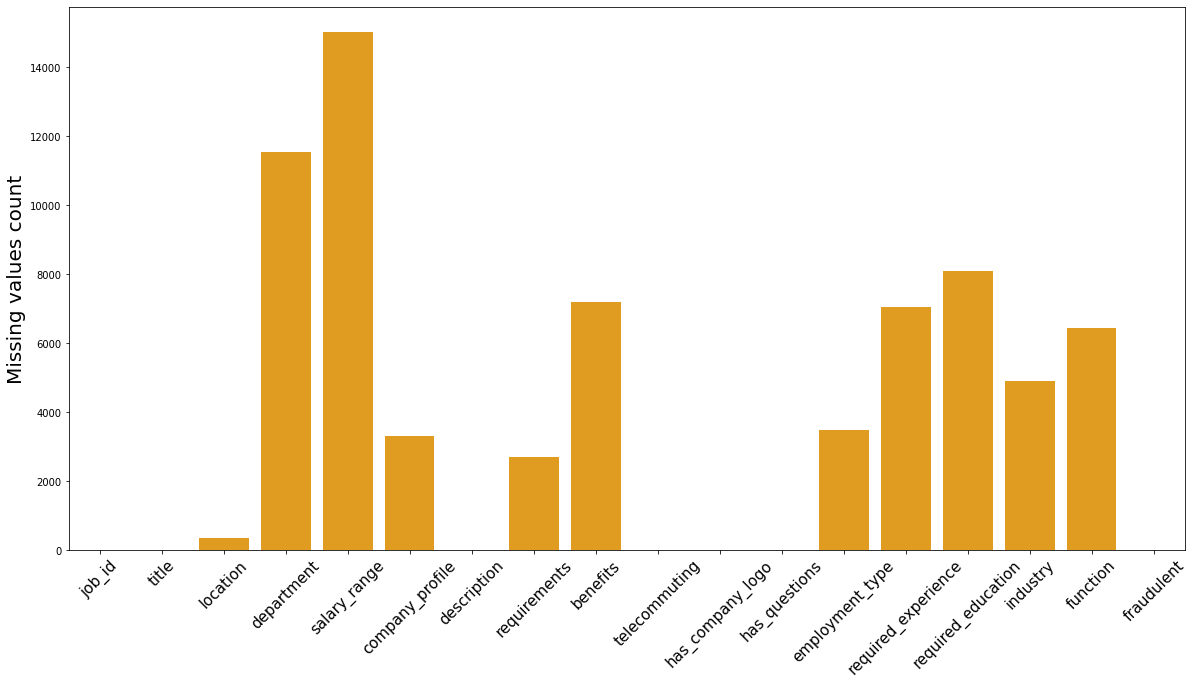

In [26]:
#check null. Most salary ranges contain null values. As most companies may only reveal it in the packages.
null_values = df.isnull().sum()
plt.figure(figsize = (20,10))
sns.barplot(x= null_values.index, y= null_values, color = 'orange')
# plt.suptitle('Missing values in the dataset', size = 20)
plt.ylabel('Missing values count', size = 20)
plt.xticks(rotation = '45', fontsize=15)
plt.show()

Finding the most frequent words in fraudulent posts

In [34]:
data = df
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

data.text.fillna(' ', inplace=True)

fraudjobs_text = data[data.fraudulent==1].text

Visulization of the most common words in fraudulant job posts using wordcloud

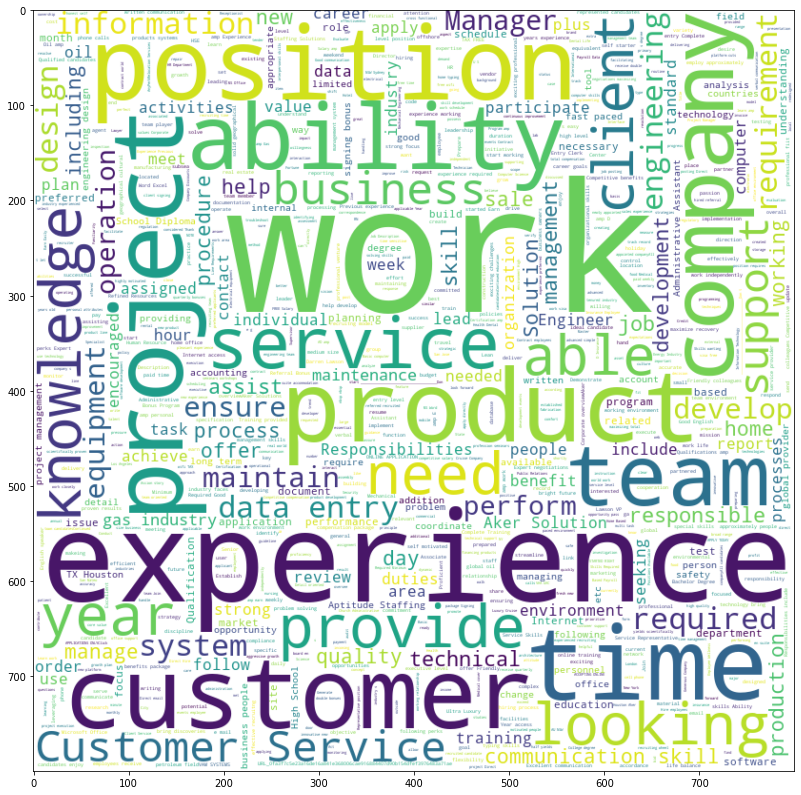

In [35]:
plt.figure(figsize = (16,14))
wc = WordCloud(background_color='white', min_font_size = 3,  max_words = 3000 , width = 800 , height = 800 , stopwords = stop_words).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

Some textual data have missing values, so going to fill those missing values with an empty space.

In [29]:
df.fillna(' ', inplace=True)


Concatenating all textual data as well as downsampling majority class. 

In [30]:
df0 = df[df['fraudulent']==0]
df0 = df0.sample(1000)

df2 = df[df['fraudulent']==1]

balanced = pd.concat([df0,df2],axis=0)
balanced["combined_text"] = balanced["title"] + " " + balanced["description"] + " " + balanced["benefits"] + " " + balanced["requirements"] + " " + balanced["salary_range"] 


train_df = balanced[["combined_text", "fraudulent"]]

print(train_df.head(5))
print()
print(f"Num Missing Values = {train_df.isnull().sum() + train_df.isna().sum()}")
print()
print(train_df.describe())

                                           combined_text  fraudulent
15119  Residential House Cleaner We are an establishe...           0
17851  Warehouse Operator / Material Handler Red Star...           0
8071   Senior Javascript/Front End Engineer (Vibrant ...           0
8468   Software Engineer StayClassy is a fast-paced s...           0
5792   PHP Developer  ConsumerTrack is a rapidly grow...           0

Num Missing Values = combined_text    0
fraudulent       0
dtype: int64

        fraudulent
count  1866.000000
mean      0.464094
std       0.498843
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


Removing punctuation, stopwords, and lemmatization

In [31]:
# spacy tokenizer

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

def spacy_tokenizer(sentence):
    # used to lemmatize the list of words
    sentence = nlp(sentence)
    
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

Going to use doc2vec to transform textual data into a vector of numerical values. Preprocessing by tokenizing the words (parsing, lemmatizing and removing stopwords)

In [32]:
tokenized = []
for row in train_df["combined_text"]:
    tokenized.append(spacy_tokenizer(row)) # calling the function to tokenize the text in each job posting

# docs = [text.split() for text in train_df["combined_text"]]
docs = tokenized
tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
doc2vec_model = Doc2Vec(tagged_docs) # can have optional vector_size to set dimensionality

Converting all the textual data into vectors using the model

In [155]:
# X = [doc2vec_model.infer_vector(doc.split()) for doc in train_df["combined_text"]]
X = [doc2vec_model.infer_vector(doc) for doc in tokenized]
Y = [y for y in train_df["fraudulent"]]

Train test split

In [156]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)


(1492, 100)


In [157]:
def build_model(input_shape, n_hidden, n_neurons_hidden, n_neurons_output, learning_rate):

    #-->add your Pyhton code here

    #Creating the Neural Network using the Sequential API
    model = keras.models.Sequential()
    # model.add(keras.layers.Flatten(input_shape=input_shape))                                #input layer

    #iterate over the number of hidden layers to create the hidden layers:
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons_hidden, activation="relu"))                   #hidden layer with ReLU activation function

    #output layer
    model.add(keras.layers.Dense(n_neurons_output, activation="softmax"))                #output layer with one neural for each class and the softmax activation function since the classes are exclusive

    #defining the learning rate
    opt = keras.optimizers.SGD(learning_rate)

    #Compiling the Model specifying the loss function and the optimizer to use.
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [158]:
classifier = build_model((100,),20, 100, 2, .2)

classifier.fit(x_train, y_train)

result = classifier.evaluate(x_test, y_test)
print(f"Toy Neural Network Accuracy: {result[1]}")


12/12 [==============================] - 0s 998us/step - loss: 0.6911 - accuracy: 0.5348
Toy Neural Network Accuracy: 0.5347593426704407


Going to try with Random Forests to see if I get better results.

In [169]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=20) #this is the number of decision trees that will be generated by Random Forest. The sample of the ensemble method used before

#Fit Random Forest to the training data
clf.fit(x_train, y_train)

pred_true = 0
pred_total = 0
   
for x, y in zip(x_test, y_test):
   pred_class = clf.predict([x])[0]
   if pred_class == y: pred_true += 1
   pred_total += 1
#printing Random Forest accuracy here
print("Random Forest accuracy: " + str(pred_true / pred_total))

Random Forest accuracy: 0.7967914438502673
